## <h2 style="font-size: 1.6em; font-weight: bold;"> 1. Data Collection </h2>
Import Required Packages and Data

**Importing Pandas, Numpy, Matplotlib, Seaborn, Plotly.express and Warings Library.**

In [969]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import plotly.express as px
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

**Import the CSV Data as Pandas DataFrame**

In [970]:
df = pd.read_csv('data/nordic_transactions_with_fraud.csv')
df.head()

,transaction_id,transaction_date,booking_date,value_date,payment_date,amount,currency,from_account_id,from_account_name,from_account_country,...,counterparty_bank_bic,counterparty_business_type,narrative,payment_purpose_code,related_trade_invoice_id,swift_message_type,transaction_status,transaction_type_description,end_to_end_identification,is_fraud
0,834c5abc-8dcc-4ccd-886f-362b8158a64d,2025-04-14,2025-04-15,2025-04-15,2025-04-17,140169.73,SEK,GB13UGOK63554643497199,"Andrews, Orozco and Rosales",NO,...,HANDFIHH,Electronics,Invoice for electronic parts,Goods,NaN,MT103,billed,Wire Transfer,e6a20348-3abf-4bbc-b5d0-418574b1fdf7,1
1,53b74d05-26bd-470a-a51d-00989fe6ecdf,2025-12-26,2025-12-26,2025-12-27,2025-12-30,318303.17,SEK,GB69AKBR67543659201137,Brooks LLC,SE,...,HANDFIHH,Consulting,morph cross-platform functionalities,Goods,NaN,MT940,failed,Direct Debit,eaf6087a-6ce5-4a8c-ae46-8edd41fef601,0
2,29f9aa86-de14-4dd2-b527-87bf5c21c426,2025-04-07,2025-04-07,2025-04-08,2025-04-08,19395.92,DKK,GB62DOXH80660432457726,Garcia PLC,DK,...,HANDFIHH,Agriculture,incubate cross-platform interfaces,Salary,NaN,MT103,billed,Card Payment,cb85e8cf-0cd9-43ec-93b5-9be80d7d63ae,0
3,b340c644-8c26-45f5-b600-997a4e234646,2025-07-03,2025-07-03,2025-07-03,2025-07-03,220571.52,EUR,GB22COCQ28390800119651,White-Woods,FI,...,HANDFIHH,Shipping,embrace plug-and-play eyeballs,Goods,NaN,MT103,failed,BG-LI-LÖN,NaN,0
4,547f0f37-55ab-4641-8e31-15196ffc2473,2025-10-28,2025-10-29,2025-10-30,2025-10-31,296657.76,SEK,GB23YJUM94655999407860,"Powell, Eaton and Harris",SE,...,NOKANO21,Electronics,exploit B2B e-commerce,Unknown,NaN,MT940,failed,Card Payment,8eea3cb7-9b0a-4e8e-a316-e75895141fa5,0


**Shape of the dataset**

In [971]:
df.shape

(10325, 25)

We have a dataset with 10,300 records and 25 columns.

In [972]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10325 entries, 0 to 10324
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   transaction_id                  10325 non-null  object 
 1   transaction_date                10325 non-null  object 
 2   booking_date                    10325 non-null  object 
 3   value_date                      10325 non-null  object 
 4   payment_date                    10325 non-null  object 
 5   amount                          10325 non-null  float64
 6   currency                        10325 non-null  object 
 7   from_account_id                 10325 non-null  object 
 8   from_account_name               10325 non-null  object 
 9   from_account_country            10325 non-null  object 
 10  from_account_business_type      10028 non-null  object 
 11  from_account_expected_turnover  10325 non-null  float64
 12  counterparty_account_id         

## <h2 style="font-size: 1.6em; font-weight: bold;"> 2. Data Wrangling </h2>
- Correlations 
- Handled missing values
- Removed duplicate entries
- Filtered billed data
- Generated dataset statistics
- Converted amounts to EUR using exchange rates from the Riskbanken open API

Before proceeding with the data cleaning, it is useful to establish a correlation between the Target variable (in our case `is_fraud`) and other predictor variables.

*Using the corr() function to list the top features based on the pearson correlation coefficient*

In [973]:
num_variables = df.select_dtypes (include=['float64', 'int64']).corr ()['is_fraud'] 
num_variables

amount                            0.018800
from_account_expected_turnover   -0.258972
is_fraud                          1.000000
Name: is_fraud, dtype: float64

Currently, the only numeric variable that correlates with `is_fraud` is `amount`. Let's explore this further!

**Create a Copy of the Dataset**

In [974]:
df_copy= df.copy()

**2.1 Handled Missing Values**

In [975]:
df_copy.isnull().sum()
df_copy.isnull().sum()*100/ len(df)

transaction_id                     0.000000
transaction_date                   0.000000
booking_date                       0.000000
value_date                         0.000000
payment_date                       0.000000
amount                             0.000000
currency                           0.000000
from_account_id                    0.000000
from_account_name                  0.000000
from_account_country               0.000000
from_account_business_type         2.876513
from_account_expected_turnover     0.000000
counterparty_account_id            0.000000
counterparty_name                  4.552058
counterparty_country               0.000000
counterparty_bank_bic              0.000000
counterparty_business_type         0.000000
narrative                          4.716707
payment_purpose_code               0.000000
related_trade_invoice_id          68.445521
swift_message_type                 0.000000
transaction_status                 0.000000
transaction_type_description    

Column names and the percentage of missing values for each column:
- `from_account_business_type` 2.9%
- `counterparty_name`          4.6%
- `narrative `          4.7%
- `related_trade_invoice_id`   68.4%
- `end_to_end_identification`  47.4% 


Replace missing values with 0

In [976]:
df_copy.fillna(0,inplace=True)

**2.2 Removed Duplicate Entries**

In [977]:
df_copy.duplicated().sum()

200

The data has 200 duplicate records. Drop all duplicate entries.

In [978]:
df_copy.drop_duplicates(inplace=True)
df_copy.duplicated().sum()

0

**2.3 Filtered billed data**

In [979]:
df_copy = df_copy.loc[df_copy['transaction_status']=='billed']
df_copy.shape

(3754, 25)

After filtering for billed transactions, the dataset comprises 3,754 records across 25 features.


 
 **2.4 Standardized transaction amounts to EUR using the open API from Riskbanken**

In [980]:
from datetime import datetime, timedelta
import urllib.request, json

# Get date (2025-04-30)
single_date = datetime.today() - timedelta(days=20)
date_str = single_date.strftime('%Y-%m-%d')

# Ensure all currency codes are uppercase
currencies = df_copy['currency'].unique()

# Build currency-to-series map
currency_to_series = {
    cur: f'SEK{cur}PMI' if cur != 'SEK' else 'SEK'
    for cur in currencies
}

rate_dict = {}

# Loop to fetch exchange rates
for cur in currencies:
    if cur == 'EUR':
        rate_dict[cur] = 1.0  # EUR to EUR
        continue
    if cur == 'SEK':
        series1 = 'SEK'
    else:
        series1 = currency_to_series[cur]

    series1 = currency_to_series[cur]
    url = f'https://api.riksbank.se/swea/v1/CrossRates/{series1}/SEKEURPMI/{date_str}/{date_str}'

    try:
        req = urllib.request.Request(url)
        req.get_method = lambda: 'GET'
        response = urllib.request.urlopen(req)
        content = response.read()
        data = json.loads(content)

        # Handle different JSON structures
        if isinstance(data, list) and data:
            rate = data[0]['value']
            rate_dict[cur] = float(rate)
        elif isinstance(data, dict) and 'value' in data:
            rate_dict[cur] = float(data['value'])
        else:
            rate_dict[cur] = 1.0

    except Exception as e:
        print(f"Error fetching rate for {cur}: {e}")
        rate_dict[cur] = 1.0

# Apply conversion to EUR
df_copy['amount_eur'] = df_copy.apply(
    lambda x: float(x['amount']) if x['currency'].upper() == 'EUR'
    else (
        float(x['amount']) / rate_dict.get('SEK', 1.0) if x['currency'].upper() == 'SEK'
        else float(x['amount']) * rate_dict.get(x['currency'].upper(), 1.0)
    ),
    axis=1
)

df_copy[['amount', 'currency','amount_eur']]


,amount,currency,amount_eur
0,140169.73,SEK,12775.803673
2,19395.92,DKK,2598.665362
5,38995.10,USD,34287.611528
11,39758.61,USD,34958.950601
14,52251.52,USD,45943.716506
...,...,...,...
10314,320704.14,SEK,29230.655790
10316,10626.53,NOK,899.865187
10318,405804.95,DKK,54369.747201
10319,147365.70,SEK,13431.682085


In [981]:
df_copy.drop(['amount'], inplace=True, axis=1)

As we have the new feature `amount_eur`, we can drop `amount`

We now have a new column that standardizes all transaction amounts in EUR. Time to dig in and uncover what secrets the data has been hiding.

## <h2 style="font-size: 1.6em; font-weight: bold;"> 3. Exploratory Data Analysis (EDA) </h2>

- Descriptive analytics: Queried the dataset using SQLite3 to understand its structure and key metrics.
- Data Distribution 
- Outlier Detection & Handling 
- Feature Scalling

**3.1 Descriptive analytics using SQL**

**Purpose:** From a business perspective, define insights: "what the data tells us?". Broken down into two components:

- Overview of Key Metrics: 

        What are the lowest and highest amounts of fraudulent transactions?

        How many fraud vs. non-fraud transactions and their percentage?
       

- Transaction Trends and Behavior:

       How many transactions were sent inside vs. outside the Nordic region?

       What are the seasonal trends for fraudulent transactions?

       How do fraudulent accounts behave?

In [982]:
!pip install ipython-sql
import sqlite3

# Connect to created in-memory database
con = sqlite3.connect(':memory:')
df_copy.to_sql ('nordic_transactions_with_fraud', con, index=False)

3754

*What are the lowest and highest amounts of fraudulent transactions?*

In [983]:
query = '''
Select 'lowest_transaction' as category, from_account_name, counterparty_country,currency, amount_eur, is_fraud 
From 
(Select *
From nordic_transactions_with_fraud
Where is_fraud = '1'
Order by amount_eur asc
Limit 1)

UNION ALL
Select 'highest_transaction' as category, from_account_name, counterparty_country,currency, amount_eur, is_fraud 
From 
(Select *
From nordic_transactions_with_fraud
Where is_fraud = '1'
Order by amount_eur desc
Limit 1)

'''

df_result = pd.read_sql_query(query, con)
df_result

,category,from_account_name,counterparty_country,currency,amount_eur,is_fraud
0,lowest_transaction,Mendez-Smith,HK,SEK,9126.258944,1
1,highest_transaction,Reed-Gonzales,RU,EUR,495108.260000,1


**Insight:**

- Fraudulent amounts span from low (small test transfers) to high (attempts to extract large sums).
- Both the lowest and highest transaction amounts were sent to high-risk countries, based on sanctions and the 2025 trade tension tariff threats.

*How many fraud vs. non-fraud transactions and their percentage?*

In [984]:
query = '''
Select 
is_fraud, count (*) as transaction_count,
Round (100.00 * COUNT(*) / 3754,2) as percentage
From nordic_transactions_with_fraud
Group by is_fraud
'''

df_result = pd.read_sql_query (query, con)
df_result

,is_fraud,transaction_count,percentage
0,0,3454,92.01
1,1,300,7.99


**Insight:**   

- Fraud is likely a small percentage (7.0%) compared to 93% of non-fraudulent transactions.

*How many transactions were sent inside vs. outside the Nordic region?*

In [985]:
query = '''
Select region, count (*) as transaction_count, 
Round (100* count (*)/ 3754, 2) as percentage
From 
(Select *,
Case when counterparty_country IN ('SE', 'NO', 'FI', 'DK', 'IS') Then 'Nordic' else 'non_Nordic' End as region
From nordic_transactions_with_fraud
)
Group by region
'''
df_result = pd.read_sql_query (query, con)
df_result

,region,transaction_count,percentage
0,Nordic,1587,42.0
1,non_Nordic,2167,57.0


**Insight:**  

- 57% of transactions were sent outside the Nordic region, indicating a higher volume of international activity.

**Suggestion:** 

- A stronger focus on global operations.

 *What are the seasonal trends for fraudulent transactions?*

In [986]:
query = '''
Select 
strftime ('%m', transaction_date) as transaction_month, count (*) as transaction_count, 
Row_number() OVER (ORDER BY count (*) DESC) AS rank
From nordic_transactions_with_fraud
WHERE is_fraud = 1
Group by transaction_month
Order by transaction_month ASC

'''
df_result = pd.read_sql_query (query, con)
df_result

,transaction_month,transaction_count,rank
0,04,31,7
1,05,36,4
2,06,27,8
3,07,36,3
4,08,31,6
5,09,24,9
6,10,33,5
7,11,37,2
8,12,45,1


In [987]:
import plotly_express as px
fig = px.line( df_result, x='transaction_month', y='transaction_count', markers=True,  color_discrete_sequence=px.colors.qualitative.Light24
)
fig.update_layout(title='Monthly Fraudulent Transaction Count')
fig.show()

**Insight:**

- Fraudulent activity showed a notable upward trend.

- December has the highest number of fraudulent transactions, which can materially affect the financial report.

- The beginning of trade tensions (April to May 2025) saw a slight increase in fraudulent transactions, which then dropped in June, possibly indicating a testing phase of fraudulent activity.

- After a decline in September, fraudulent transactions sharply increased.

**Suggestion:**

- Implement heightened fraud detection and monitoring systems during the end-of-year months.

- Focus on trade-related transactions, especially during geopolitical instability.


**3.2 Data Distribution, Outlier Detection & Handling**

Let's have a quick look at the data distribution from a statistical perspective and visualization.

In [988]:
df_copy.describe()

,from_account_expected_turnover,is_fraud,amount_eur
count,3.754000e+03,3754.000000,3754.000000
mean,8.459075e+05,0.079915,86354.912759
std,6.206570e+05,0.271197,124582.882511
min,5.000191e+04,0.000000,32.778563
25%,2.332640e+05,0.000000,18681.233340
50%,7.962714e+05,0.000000,33252.249465
75%,1.391445e+06,0.000000,61537.795103
max,1.999250e+06,1.000000,499959.970000


Target variable `is_fraud` 

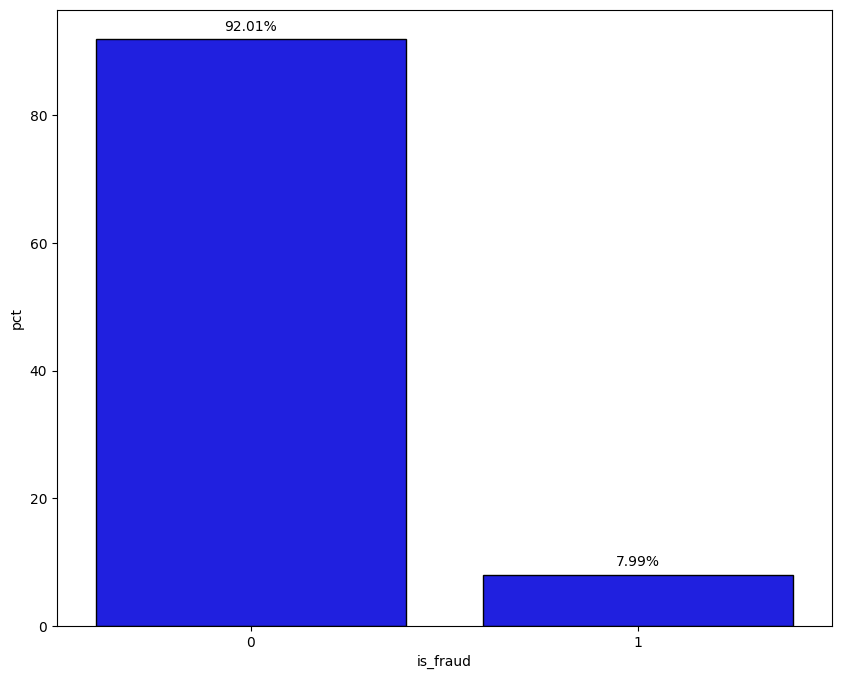

In [989]:
fraud_counts = (100.00* df_copy['is_fraud'].value_counts()/ len(df_copy)).sort_index()
fraud_df = fraud_counts.reset_index()
fraud_df.columns = ['is_fraud','pct']

plt.figure (figsize=(10,8))
ax = sns.barplot(fraud_df, x='is_fraud', y='pct',color='blue', edgecolor='black')

for index,row in fraud_df.iterrows():
    ax.text (x=index, y=row['pct'] + 0.9, s=f"{row['pct']:.2f}%", ha='center', va='bottom')

plt.show()

Feature `amount_eur`

In [990]:
import plotly.express as px
fig=px.histogram (df_copy['amount_eur'], x='amount_eur', title= 'Transaction Amount Distribution', nbins=100)
fig.update_traces(marker=dict (line = dict (color='black', width=1)))
fig.update_layout(width=1000, height=500)
fig.show()

- Compared to the overall dataset, `amount_eur` has a significantly larger scale and should be normalized to ensure consistent 

Therefore, a transformation should be applied before training.

**3.3 Outlier Detection & Handling**

Feature `amount_eur` 

As you see, `amount_eur` is skewed, so we will use IQR method (Interquartile Range) to find outliers


In [991]:
fig = px.box (df_copy, y= 'amount_eur', title='Transaction Amount Distribution - Outlier Detection') 
fig.update_layout( width= 700, height= 800)
fig.show()

In [992]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df_copy['amount_eur'].quantile(0.25)
Q3 = df_copy['amount_eur'].quantile(0.75)

# Calculate IQR
IQR = Q3 - Q1

# Define the lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = df_copy[(df_copy['amount_eur'] < lower_bound) | (df_copy['amount_eur'] > upper_bound)] 
outliers.shape

(740, 25)

`amount_eur` contains 740 records identified as outliers.

Let’s try removing them.

In [993]:
df_copy = df_copy[(df_copy['amount_eur'] >= lower_bound) & (df_copy['amount_eur'] <= upper_bound)]
df_copy.shape

(3014, 25)

Let's see how the data in `amount_eur` distributed after removing outliers!

In [994]:
import plotly.express as px
fig=px.histogram (df_copy['amount_eur'], x='amount_eur', title= 'Transaction Amount Distribution', nbins=100)
fig.update_traces(marker=dict (line = dict (color='black', width=1)))
fig.update_layout(width=1000, height=500)
fig.show()

## <h2 style="font-size: 1.6em; font-weight: bold;"> 4. Feature Engineering </h2>
 
- Feature Transformation  
  - New Features Creation  
  - Date-time Transformation  
  - Categorical Variables Transformation (Using TF-IDF and One-Hot Encoding)  
  - Continuous Variable Transformation


- Feature Selection

- Feature Scaling

**4.1 Feature Transformation**

*New Features Creation*

`turnover_jump_pct`

Calculate the Turnover Jump % to spot any unusual spikes in transaction volumes that could indicate suspicious activity.

In [995]:
df_copy.rename(columns={'from_account_expected_turnover': 'expected_turnover'}, inplace=True) 
df_copy['turnover_jump_pct'] = (100.00* df_copy['amount_eur']/ df_copy['expected_turnover']).round(2)
df_copy [['currency','amount_eur', 'expected_turnover', 'turnover_jump_pct']]

,currency,amount_eur,expected_turnover,turnover_jump_pct
0,SEK,12775.803673,72212.29,17.69
2,DKK,2598.665362,883638.24,0.29
5,USD,34287.611528,78046.80,43.93
11,USD,34958.950601,71703.24,48.76
14,USD,45943.716506,63768.28,72.05
...,...,...,...,...
10314,SEK,29230.655790,1464047.29,2.00
10316,NOK,899.865187,1881194.82,0.05
10318,DKK,54369.747201,543310.95,10.01
10319,SEK,13431.682085,1214167.80,1.11


In [996]:
count_turnover_jump = (df_copy['turnover_jump_pct'] > 100.00).sum ()
count_turnover_jump

23

We found 23 transactions with a turnover jump percentage over 100%.

In [997]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# Create subplot layout: 2 rows, 1 column
fig = make_subplots(rows=2, cols=1, shared_xaxes=False, subplot_titles=(
    "Turnover Jump % Distribution", "Expected Turnover Distribution"))

# Add first histogram
fig.add_trace(
    go.Histogram(x=df_copy['turnover_jump_pct'], marker=dict(line=dict(color='black', width=1))),
    row=1, col=1
)

# Add second histogram
fig.add_trace(
    go.Histogram(x=df_copy['expected_turnover'], marker=dict(line=dict(color='black', width=1))),
    row=2, col=1
)

# Update layout
fig.update_layout(height=600, width=800, showlegend=False)
fig.show()

`risky_flag`

Flag all transactions sent to risky countries (as defined by sanctions and potential tariff threats)


In [998]:
risky_countries = ['HK', 'SG', 'CN', 'RU']

df_copy['is_rirsk _country'] = df_copy['counterparty_country'].isin(risky_countries).astype(int)

df_copy[['counterparty_country','is_rirsk _country']]

,counterparty_country,is_rirsk _country
0,HK,1
2,FI,0
5,RU,1
11,SG,1
14,RU,1
...,...,...
10314,NO,0
10316,NO,0
10318,FI,0
10319,NO,0


In [999]:
count_countries_flag = (df_copy['is_rirsk _country'] == 1).sum()
count_countries_flag

1070

We found 1,070 transactions sent to risky countries.

`split_payment`

To flag slip_payment, we applied business rules to identify accounts that show any of these signs:

- Made multiple payments within a single day.

- Had repeated or similar transaction amounts

- Made more than a set number of payments (high frequency).

In [1000]:
# Case 1: Made multiple payments within a single day
df_copy['transaction_date'] = pd.to_datetime(df_copy['transaction_date'])
df_copy['time_diff'] = df_copy.groupby('from_account_name')['transaction_date'].diff()
df_copy['is_sequential'] = (df_copy['time_diff'] <= pd.Timedelta(days=1)).astype(int)

# Case 2: Had repeated or similar transaction amounts
df_copy['is_repeated_amount'] = df_copy.groupby('from_account_name')['amount_eur'].transform(
    lambda x: x.duplicated(keep=False)
).astype(int)

# Case 3: Made more than 3 payments (high frequency)
txn_count = df_copy.groupby('from_account_name')['transaction_id'].transform('count')
df_copy['is_high_frequency'] = (txn_count >= 3).astype(int)

# Final flag: if any condition is met
df_copy['split_payment_flag'] = ( df_copy['is_sequential'] | df_copy['is_repeated_amount'] | df_copy['is_high_frequency']
)

count_split_payment = (df_copy['split_payment_flag'] ==1).sum()
count_split_payment

179

In [1001]:
df_copy.drop(['time_diff','is_repeated_amount'],inplace=True, axis=1)

We have 179 transactions marked as split payments.

*Date-times Transformation*

Convert  `transaction_date`, `booking_date`, `value_date`, and `payment_date` from object type to datetime format, then transform them into numeric columns, suitable for machine learning algorithms.

In [1002]:
df_copy['transaction_day'] = df_copy['transaction_date'].dt.day
df_copy['transaction_month'] = pd.to_datetime(df_copy['transaction_date']).dt.month


df_copy['booking_day'] = pd.to_datetime(df_copy['booking_date']).dt.day
df_copy['booking_month'] = pd.to_datetime(df_copy['booking_date']).dt.month


df_copy['value_day'] = pd.to_datetime(df_copy['value_date']).dt.day
df_copy['value_month'] = pd.to_datetime(df_copy['value_date']).dt.month


df_copy['payment_day'] = pd.to_datetime(df_copy['payment_date']).dt.day
df_copy['payment_month'] = pd.to_datetime(df_copy['payment_date']).dt.month

In [1003]:
df_copy.select_dtypes(include='number')

,expected_turnover,is_fraud,amount_eur,turnover_jump_pct,is_rirsk _country,is_sequential,is_high_frequency,split_payment_flag,transaction_day,transaction_month,booking_day,booking_month,value_day,value_month,payment_day,payment_month
0,72212.29,1,12775.803673,17.69,1,0,0,0,14,4,15,4,15,4,17,4
2,883638.24,0,2598.665362,0.29,0,0,1,1,7,4,7,4,8,4,8,4
5,78046.80,0,34287.611528,43.93,1,0,0,0,2,7,2,7,3,7,3,7
11,71703.24,0,34958.950601,48.76,1,0,0,0,15,7,16,7,17,7,18,7
14,63768.28,0,45943.716506,72.05,1,0,0,0,12,11,13,11,14,11,16,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10314,1464047.29,0,29230.655790,2.00,0,0,0,0,2,4,4,4,5,4,7,4
10316,1881194.82,0,899.865187,0.05,0,1,1,1,16,8,17,8,17,8,20,8
10318,543310.95,0,54369.747201,10.01,0,0,0,0,18,9,20,9,20,9,23,9
10319,1214167.80,0,13431.682085,1.11,0,0,0,0,25,10,26,10,26,10,29,10


In [1004]:
df_copy.drop(['transaction_date','booking_date','value_date','payment_date'], inplace=True, axis=1)

In [1005]:
df_copy.select_dtypes(include=['object']).columns

Index(['transaction_id', 'currency', 'from_account_id', 'from_account_name',
       'from_account_country', 'from_account_business_type',
       'counterparty_account_id', 'counterparty_name', 'counterparty_country',
       'counterparty_bank_bic', 'counterparty_business_type', 'narrative',
       'payment_purpose_code', 'related_trade_invoice_id',
       'swift_message_type', 'transaction_status',
       'transaction_type_description', 'end_to_end_identification'],
      dtype='object')

*Categorical Variables Transformation*

In [1006]:
df_copy.select_dtypes(include='object').value_counts()

transaction_id                        currency  from_account_id         from_account_name          from_account_country  from_account_business_type  counterparty_account_id  counterparty_name            counterparty_country  counterparty_bank_bic  counterparty_business_type  narrative                                payment_purpose_code  related_trade_invoice_id              swift_message_type  transaction_status  transaction_type_description  end_to_end_identification           
00068f11-771b-4afa-9fce-56972c7a0a5b  NOK       GB78WVEM83492263935946  Chavez-Anderson            NO                    Electronics                 GB47IGAG14013819426850   Franklin-Love                FI                    DABADKKK               Shipping                    optimize bleeding-edge e-commerce        Salary                bef2e955-73a8-4cc3-bfe4-c9b42aa77fd0  MT202               billed              BG-LI-LÖN                     0                                       1
ae2b6589-2add-47c4-a305-8a6

In [1007]:
df_copy.drop(['transaction_id','from_account_id', 'counterparty_account_id', 'related_trade_invoice_id','transaction_status','end_to_end_identification'], inplace=True, axis=1)

In [1008]:
df_copy['narrative'].unique().tolist()

['Invoice for electronic parts',
 'incubate cross-platform interfaces',
 'Payment for services',
 'iterate holistic action-items',
 'cultivate revolutionary users',
 'scale value-added web-readiness',
 'transition real-time experiences',
 'drive wireless web services',
 'generate global supply-chains',
 'maximize one-to-one architectures',
 'expedite distributed e-commerce',
 'aggregate global content',
 0,
 'architect B2C interfaces',
 'engage proactive web-readiness',
 'evolve proactive methodologies',
 'visualize bleeding-edge models',
 'leverage real-time partnerships',
 'aggregate clicks-and-mortar convergence',
 'brand ubiquitous portals',
 'transform vertical architectures',
 'synergize bleeding-edge solutions',
 'enhance synergistic action-items',
 'exploit plug-and-play architectures',
 'seize front-end eyeballs',
 'target innovative portals',
 'orchestrate innovative relationships',
 'expedite magnetic platforms',
 'drive impactful solutions',
 'disintermediate B2C supply-cha

As `narrative` column has a lot of text, so we can use the TF-IDF technique to keeps only the top 10 most informative words. 

In [1009]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english', max_features=10)
tfidf_matrix = tfidf.fit_transform(df_copy['narrative'].astype(str))

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())
tfidf_df.index = df_copy.index

df_copy = pd.concat([df_copy, tfidf_df], axis=1)

Perform One-Hot Encoding using the `get_dummies()` function.

In [1010]:
one_hot_encode_cols = df_copy.dtypes[df_copy.dtypes=='object']
one_hot_encode_cols = one_hot_encode_cols.index.tolist()  
df_copy = pd.get_dummies(df_copy, columns=one_hot_encode_cols, drop_first=True)
df_copy.head().T

,0,2,5,11,14
expected_turnover,72212.29,883638.24,78046.8,71703.24,63768.28
is_fraud,1,0,0,0,0
amount_eur,12775.803673,2598.665362,34287.611528,34958.950601,45943.716506
turnover_jump_pct,17.69,0.29,43.93,48.76,72.05
is_rirsk _country,1,0,1,1,1
...,...,...,...,...,...
swift_message_type_MT202,False,False,False,False,False
swift_message_type_MT940,False,False,False,False,False
transaction_type_description_Card Payment,False,True,False,False,False
transaction_type_description_Direct Debit,False,False,False,False,False


Optional: Another alternative is to perform One-Hot Encoding using the `OneHotEncode()` function.

In [1011]:
#from sklearn.preprocessing import OneHotEncoder
#from sklearn.compose import ColumnTransformer

#categorical_cols = df_copy.select_dtypes(include='object').columns.tolist()

# Convert categorical columns to string (avoid dtype issues)
#df_copy[categorical_cols] = df_copy[categorical_cols].astype(str)

# Setup ColumnTransformer to one-hot encode categorical columns and pass through others
#preprocessor = ColumnTransformer(
#    transformers=[
#        ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'), categorical_cols)
#    ],
#    remainder='passthrough'  # Keep other columns as-is
#)

# Fit and transform the whole dataset
#processed_array = preprocessor.fit_transform(df_copy)

# Get feature names for the encoded categorical columns plus passthrough columns
#encoded_feature_names = preprocessor.get_feature_names_out()

# Convert the processed data back to DataFrame
#df_processed = pd.DataFrame(processed_array, columns=encoded_feature_names, index=df_copy.index)

*Continuous Variable Transformation*

In [1012]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3014 entries, 0 to 10321
Columns: 8049 entries, expected_turnover to transaction_type_description_Wire Transfer
dtypes: bool(8023), float64(13), int32(12), int64(1)
memory usage: 23.5 MB


Currently, we have mixed data types, so I will standardize them to facilitate transformation.

In [ ]:
int_cols = df_copy.select_dtypes(include='int').columns
df_copy[int_cols] = df_copy[int_cols].apply(lambda x: x.astype('float'))
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3014 entries, 0 to 10321
Columns: 8049 entries, expected_turnover to transaction_type_description_Wire Transfer
dtypes: bool(8023), float64(26)
memory usage: 23.7 MB


Let’s check if the data is skewed using some statistical methods.

In [1026]:
from scipy.stats.mstats import normaltest 

num_cols = df_copy.select_dtypes(include='float')
for col in num_cols:
    stat, p = normaltest(df_copy[col])
    result = "Not Normal (p < 0.05)" if p < 0.05 else "Normal (p ≥ 0.05)"
    print(f"{col}: statistic = {stat:.4f}, p-value = {p:.4f} → {result}")


expected_turnover: statistic = 6598.1961, p-value = 0.0000 → Not Normal (p < 0.05)
is_fraud: statistic = 2640.3554, p-value = 0.0000 → Not Normal (p < 0.05)
amount_eur: statistic = 908.7928, p-value = 0.0000 → Not Normal (p < 0.05)
turnover_jump_pct: statistic = 1813.9283, p-value = 0.0000 → Not Normal (p < 0.05)
is_rirsk _country: statistic = 14840.8582, p-value = 0.0000 → Not Normal (p < 0.05)
is_sequential: statistic = 3036.7475, p-value = 0.0000 → Not Normal (p < 0.05)
is_high_frequency: statistic = 2710.6452, p-value = 0.0000 → Not Normal (p < 0.05)
split_payment_flag: statistic = 2259.7370, p-value = 0.0000 → Not Normal (p < 0.05)
transaction_day: statistic = 2260.8071, p-value = 0.0000 → Not Normal (p < 0.05)
transaction_month: statistic = 2518.7951, p-value = 0.0000 → Not Normal (p < 0.05)
booking_day: statistic = 2080.1133, p-value = 0.0000 → Not Normal (p < 0.05)
booking_month: statistic = 1601.0174, p-value = 0.0000 → Not Normal (p < 0.05)
value_day: statistic = 2026.5639, p

**4.2 Feature Selection**

*For Continuous Variables.*

In [ ]:
corr = df_copy.corr(numeric_only=True)

plt.figure (figsize=(18,18))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title = '"Correlation with is_fraud"'
plt.show()

In [ ]:
features = df_copy.corr(numeric_only=True)['is_fraud'].sort_values()
features.plot(kind='bar',figsize=(10,8))